### INIT

In [ ]:
import os
import torch
import numpy as np
from shapely.geometry import Polygon
import scipy.io as sio
import json
from PIL import Image

import sys
sys.path.append('src')

from vican.cam import estimate_pose_mp, SE3
from vican.bipgo import bipartite_se3sync
from vican.dataset import Dataset

# remove all timestep with less than 2 cameras
def filter_dataset(dataset_path='dataset/Dataset_Sensei/contlabs/aruco_images_samples'):
    for timestep in os.listdir(dataset_path):
        if not os.path.isdir(os.path.join(dataset_path, timestep)):
            print(f'{timestep} is not a directory')
            continue

        os.system(f'rm {os.path.join(dataset_path, timestep, ".gitkeep")} 2>/dev/null')

        cameras = [i for i in os.listdir(os.path.join(dataset_path, timestep)) if i.endswith('.jpg')]
        if len(cameras) < 2:
            print(f'Not enough cameras for timestep {timestep}')
            os.system(f'rm -rf {os.path.join(dataset_path, timestep)}')

# get resolution of all images in a dataset
def get_all_resolutions(folder='dataset/Dataset_Sensei/contlabs/aruco_images_samples'):
    resolutions = set()

    for directory in os.listdir(folder):
        if not os.path.isdir(f'{folder}/{directory}'):
            continue
        os.system(f'rm {folder}/{directory}/.gitkeep 2> /dev/null')

        if len(os.listdir(f'{folder}/{directory}')) < 2:
            os.system(f'rm -rf {folder}/{directory}')
            continue
        # print(f'{folder}/{directory}')
        for file in os.listdir(f'{folder}/{directory}'):
            if file.endswith('jpg'):
                resolutions.add(Image.open(f'{folder}/{directory}/{file}').size)

    return resolutions

# convert file of intrinsics to cameras.json
def generate_cameras_json(intrinsics_path='dataset/Dataset_Sensei/contlabs/cameras_intrinsics.json', cameras_path='dataset/Dataset_Sensei/contlabs/aruco_images_samples/cameras.json'):
    data = json.load(open(intrinsics_path))
    new_data = {}
    for i in data:
        intrinsics = data[i]['intrinsics']
        distortion = data[i]['distortion']
        new_data[i] = {
            'fx': intrinsics[0][0],
            'fy': intrinsics[1][1],
            'cx': intrinsics[0][2],
            'cy': intrinsics[1][2],
            'resolution_x': 1280,
            'resolution_y': 720,
            'distortion': distortion
        }

    print(new_data.keys())
    json.dump(new_data, open(cameras_path, 'w'), indent=4)

# read object file and create obj_pose_est
def get_obj_pose_est(file_path='dataset/Dataset_Sensei/contlabs/aruco_cube_transformations.json'):
    data = json.load(open(file_path))
    obj_pose_est = {}

    for i in data['to']:
        if not i == 'floor':
            obj_pose_est[i] = SE3(pose=np.array(data['to'][i]))

    return obj_pose_est

# calibrate cameras with object pose estimation and cameras dataset
def get_cam_pose_est(obj_pose_est, dataset_path='dataset/Dataset_Sensei/contlabs/aruco_images_samples', err=0.5):
    dataset = Dataset(root=dataset_path)

    MARKER_IDS = list(obj_pose_est.keys())

    cam_marker_edges = estimate_pose_mp(cams=dataset.im_data['cam'],
                                        im_filenames=dataset.im_data['filename'],
                                        aruco='DICT_4X4_1000',
                                        marker_size=0.575,
                                        corner_refine='CORNER_REFINE_SUBPIX',
                                        marker_ids=MARKER_IDS,
                                        flags='SOLVEPNP_IPPE_SQUARE',
                                        brightness=-50,
                                        contrast=100)

    pose_est = bipartite_se3sync(cam_marker_edges,
                                constraints=obj_pose_est,
                                noise_model_r=lambda edge : 1, #0.001 * Polygon(zip(edge['corners'][:,0], edge['corners'][:,1])).area**1.0,
                                noise_model_t=lambda edge : 1, #0.001 * Polygon(zip(edge['corners'][:,0], edge['corners'][:,1])).area**1.0,
                                edge_filter=lambda edge : edge['reprojected_err'] < err,
                                maxiter=4,
                                lsqr_solver="conjugate_gradient",
                                dtype=np.float32)
    return pose_est

# generate output file for pose of cameras
def cam_pose_est_json_dump(pose_est, file_path='pose_est.json'):
    json_data = {}
    for i in pose_est:
        json_data[i] = {'R': pose_est[i].R().tolist(), 't': pose_est[i].t().tolist()}

    json.dump(json_data, open(file_path, 'w'), indent=4)

### Reprojection error analysis

In [ ]:
generate_cameras_json(intrinsics_path='small_dataset/cameras_intrinsics.json', cameras_path='small_dataset/aruco_images_samples/cameras.json')
dataset = Dataset(root='small_dataset/aruco_images_samples')

MARKER_IDS = ['0', '1', '2', '3', '4']

cam_marker_edges = estimate_pose_mp(cams=dataset.im_data['cam'],
                                    im_filenames=dataset.im_data['filename'],
                                    aruco='DICT_4X4_1000',
                                    marker_size=0.575,
                                    corner_refine='CORNER_REFINE_SUBPIX',
                                    marker_ids=MARKER_IDS,
                                    flags='SOLVEPNP_IPPE_SQUARE',
                                    brightness=-50,
                                    contrast=100)
len(cam_marker_edges.keys())

In [ ]:
# plot an histogram of the reprojected errors
import matplotlib.pyplot as plt
import numpy as np

errors = np.array([edge['reprojected_err'] for edge in cam_marker_edges.values()])
plt.hist(errors, bins=100)
plt.show()

error = 0.5
errors_2 = np.sum(errors < error)
print(f'Errors < {error}: {errors_2} of {len(errors)} ({errors_2/len(errors)*100:.2f}%)')
print(f'Mean error: {np.mean(errors)}\nMax error: {np.max(errors)}\nMin error: {np.min(errors)}')



In [ ]:
im_errors = np.array([int(edge['im_filename'].split('/')[-1].split('.')[0]) for edge in cam_marker_edges.values()])

cameras_filter = []
for i in np.unique(im_errors):
    errors_i = errors[im_errors == i]
    percentage = np.sum(errors_i < error) / len(errors_i) * 100
    if percentage > 99:
        cameras_filter.append(i)
        print(f'{i}: Errors < {error}: ({percentage:.2f}%)')
    
    # plt.hist(errors_i, bins=100)
    # plt.title(f'{i}')
    # plt.show()
    # print(f'Mean error: {np.mean(errors_i)}\nMax error: {np.max(errors_i)}\nMin error: {np.min(errors_i)}')

### Main

In [103]:
# build_small_dataset(cameras_number=1000)
generate_cameras_json(intrinsics_path='small_dataset/cameras_intrinsics.json', cameras_path='small_dataset/aruco_images_samples/cameras.json')

obj_pose_est = get_obj_pose_est(file_path='small_dataset/aruco_cube_transformations.json')
pose_est = get_cam_pose_est(obj_pose_est, dataset_path='small_dataset/aruco_images_samples', err=0.5)
cam_pose_est_json_dump(pose_est)

dict_keys(['1', '2', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '153', '154', '155', '156', '157', '158', '159', '1






Optimizing: 100%|██████████| 4/4 [00:00<00:00, 59.17it/s, eigengap=3.738e+00, evals0=-4.365e-03, evals1=1.669e-01, evals2=3.124e-01]

Building sparse 72x45 incidence matrix (0.003s).
Solving sparse linear system (0.003s).
Done!


### Generate cameras_intrinsics.json file with camera '159' repeated

In [ ]:
new_data = {}
json_data = json.load(open('dataset/Dataset_Sensei/contlabs/cameras_intrinsics.json'))
for i in json_data:
    new_data[i] = json_data['159']

json.dump(new_data, open('cameras_intrinsics.json', 'w'), indent=4)

### Analyse Camera Distortion Coefficients

In [84]:
# Get all distortion coefficients

import json
import numpy as np
import matplotlib.pyplot as plt

json_data = json.load(open('dataset/Dataset_Sensei/contlabs/cameras_intrinsics.json'))
max_idx = max([int(i) for i in json_data])
distortion_coefficients = np.zeros((max_idx + 1, 8))
intrinsics = np.zeros((max_idx + 1, 3, 3))

for i, coeffs in enumerate(json_data):
    intrinsics[int(coeffs)] += np.array(np.array(json_data[coeffs]['intrinsics']))
    distortion_coefficients[int(coeffs)] += np.array(json_data[coeffs]['distortion'][0])[:8]

intrinsics.shape, distortion_coefficients.shape


((252, 3, 3), (252, 8))

/Users/goncalofrazao/vican/slim-env/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


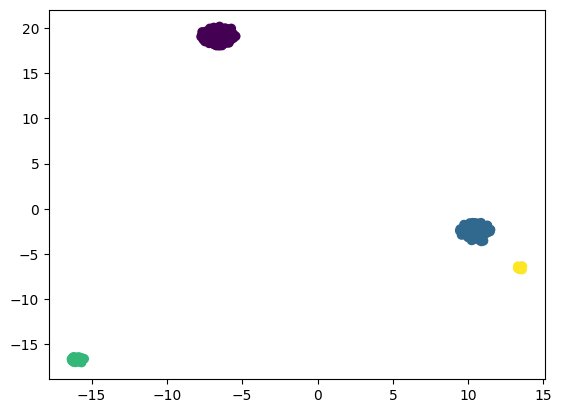

In [85]:
# cluster the dirtortion coefficients

from sklearn.cluster import KMeans
import umap

kmeans = KMeans(n_clusters=4, random_state=42)
labels = kmeans.fit_predict(distortion_coefficients)

reducer = umap.UMAP(n_components=2, random_state=42)
embeddings = reducer.fit_transform(distortion_coefficients)

plt.scatter(embeddings[:,0], embeddings[:,1], c=labels)
plt.show()

In [ ]:
# Plot all

import glob
import cv2
import matplotlib.pyplot as plt
import json
import numpy as np

dataset = 'Dataset_Sensei/contlabs'
cluster = 1

dataset_path = f'dataset/{dataset}/aruco_images_samples'
all_cameras = set([int((i.split('.')[0]).split('/')[-1]) for i in glob.glob(f'{dataset_path}/*/*.jpg')])

intrinsics_data = json.load(open(f'dataset/{dataset}/cameras_intrinsics.json'))

for i in all_cameras:
    if labels[i] != cluster:
        continue
    ims = [cv2.imread(im) for im in glob.glob(f'{dataset_path}/*/{i}.jpg')]
    undistorted_im = [cv2.undistort(im, intrinsics[i], distortion_coefficients[i]) for im in ims]

    fig, axs = plt.subplots(1, 5, figsize=(15,5))
    for ax in axs:
        ax.axis('off')
    for im, ax in zip(undistorted_im, axs):
        ax.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
    plt.title(f'Undistorted images from camera {i}')
    plt.show()

### Create a dataset with selected cameras

In [104]:
import glob
import os

def clean_dataset(dataset_path):
    for i in glob.glob(f'{dataset_path}/aruco_images_samples/*'):
        if len(glob.glob(f'{i}/*.jpg')) < 2:
            os.system(f'rm -rf {i}')

def build_small_dataset(cameras_list, old_dataset_path='dataset/Dataset_Sensei/contlabs', new_dataset_path='small_dataset'):
    os.makedirs(new_dataset_path, exist_ok=True)
    os.system(f'cp -r {old_dataset_path}/* {new_dataset_path}')

    for i in glob.glob(f'{new_dataset_path}/aruco_images_samples/*/*.jpg'):
        if int(i.split('/')[-1].split('.')[0]) not in cameras_list:
            os.system(f'rm {i}')
    
cameras_list = set(np.where(labels == 1)[0])
build_small_dataset(cameras_list)
clean_dataset('small_dataset')

In [105]:
import glob

dataset_path = 'small_dataset/aruco_images_samples'
idx2camera = sorted(list(set([int(i.split('/')[-1].split('.')[0]) for i in glob.glob(f'{dataset_path}/*/*.jpg')])))
camera2idx = {camera_id: i for i,camera_id in enumerate(idx2camera)}

appearances = np.array([len(glob.glob(f'{dataset_path}/*/{camera_id}.jpg')) for camera_id in idx2camera])
idx2camera = np.array(idx2camera)

# cameras_filter = [int(i.split('.')[0].split('/')[-1]) for i in glob.glob(f'{dataset_path}/111/*.jpg')]
cameras_filter = [141, 155, 168]
for i in idx2camera:
    if i not in cameras_filter:
        for im in glob.glob(f'{dataset_path}/*/{i}.jpg'):
            os.system(f'rm {im}')

clean_dataset('small_dataset')

In [ ]:
dataset_path = 'small_dataset/aruco_images_samples'
timesteps = np.array(sorted([int(i) for i in os.listdir(dataset_path)]))
timesteps_density = np.array([len(glob.glob(f'{dataset_path}/{timestep}/*.jpg')) for timestep in timesteps])
# timesteps[timesteps_density == 4]
timesteps_density

### Check if graph is connected

In [ ]:
from scipy.sparse import csgraph
import glob
import os
import numpy as np

dataset_path = 'small_dataset/aruco_images_samples'
idx2camera = set(sorted([int(i.split('/')[-1].split('.')[0]) for i in glob.glob(f'{dataset_path}/*/*.jpg')]))
camera2idx = {camera_id: i for i,camera_id in enumerate(idx2camera)}

adjacency_matrix = np.zeros((len(idx2camera), len(idx2camera)), dtype=int)

for timestep in os.listdir(dataset_path):
    timestep_path = f'{dataset_path}/{timestep}'
    if not os.path.isdir(timestep_path):
        continue

    cameras = [int(i.split('/')[-1].split('.')[0]) for i in glob.glob(f'{timestep_path}/*.jpg')]

    for i in range(len(cameras)):
        for j in range(i+1, len(cameras)):
            adjacency_matrix[camera2idx[cameras[i]], camera2idx[cameras[j]]] += 1
            adjacency_matrix[camera2idx[cameras[j]], camera2idx[cameras[i]]] += 1


x = csgraph.connected_components(adjacency_matrix, directed=False)
x, idx2camera
[idx for i, idx in enumerate(idx2camera) if x[1][i] == 2]


### Test PNP

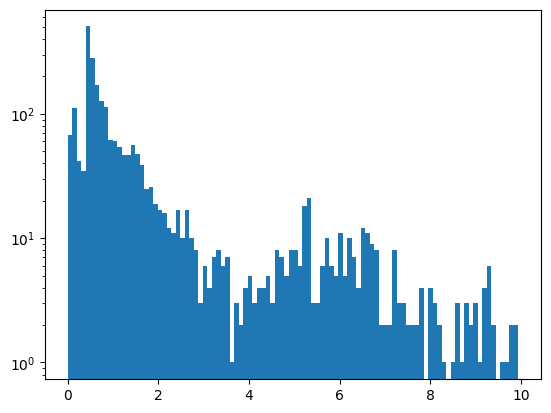

In [83]:
import cv2
import json
import numpy as np
import matplotlib.pyplot as plt
import glob

arucos_distance = []

# dataset_path = 'dataset/Dataset_Sensei/contlabs/aruco_images_samples/*/*.jpg'
dataset_path = 'small_dataset/aruco_images_samples/*/*.jpg'
for f in glob.glob(dataset_path):
    im = cv2.imread(f)
    gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    
    camera_id = f.split('/')[-1].split('.')[0]
    camera_data = json.load(open('small_dataset/cameras_intrinsics.json'))[str(camera_id)]
    intrinsics, distortion = np.array(camera_data['intrinsics']), np.array(camera_data['distortion'])

    dictionary = cv2.aruco.Dictionary_get(cv2.aruco.DICT_4X4_1000)
    parameters = cv2.aruco.DetectorParameters_create()
    marker_corners, marker_ids, _ = cv2.aruco.detectMarkers(gray, dictionary, parameters=parameters)

    if marker_ids is None:
        continue

    marker_corners = np.array(marker_corners).reshape(-1, 4, 2)
    marker_ids = np.array(marker_ids).flatten()

    marker_corners = marker_corners[marker_ids < 5]
    marker_ids = marker_ids[marker_ids < 5]

    marker_points = np.array([[-1, 1, 0],
                                [1, 1, 0],
                                [1, -1, 0],
                                [-1, -1, 0]], dtype=np.float32)
    marker_points *= 0.575 * 0.5
    points3d = np.zeros((len(marker_corners), 3))

    for i in range(len(marker_corners)):
        flag, r, t = cv2.solvePnP(marker_points,
                           imagePoints=marker_corners[i].squeeze(),
                           cameraMatrix=intrinsics,
                           distCoeffs=distortion)

        if not flag:
            continue

        r, t = cv2.solvePnPRefineLM(marker_points,
                                    imagePoints=marker_corners[i].squeeze(),
                                    cameraMatrix=intrinsics,
                                    distCoeffs=distortion,
                                    rvec=r,
                                    tvec=t)
        
        points3d[i] += t.reshape(-1)

    for corner in marker_corners:
        cv2.drawContours(im, [corner.astype(int)], -1, (0, 255, 0), 2)
    
    if len(points3d) < 2:
        continue

    for i in range(len(points3d)):
        for j in range(i+1, len(points3d)):
            arucos_distance.append(np.linalg.norm(points3d[i] - points3d[j]))
            # if arucos_distance[-1] > 1:
            #     plt.imshow(im)

            #     plt.title(f)
            #     plt.show()

arucos_distance = np.array(arucos_distance)
arucos_distance = arucos_distance[arucos_distance < 10]

plt.hist(arucos_distance, bins=100)
plt.show()


### Delete all images of a camera from a dataset

In [ ]:
import glob

cameras_to_remove = glob.glob('small_dataset/aruco_images_samples/*/111.jpg')
for camera in cameras_to_remove:
    os.remove(camera)